In [1]:
from wasserstein.basic_wasserstein import compute_wasserstein_sliced_distance
from utils.image_treatment import preprocess_image
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from wasserstein.texture_mixing import compute_steerable_pyramid_coeffs
from wasserstein.basic_wasserstein import compute_sliced_wass_barycenter
import pyrtools as pt
from tqdm import tqdm 
import ot
from utils.image_treatment import preprocess_image, image_to_distribution
from wasserstein.basic_wasserstein import compute_wasserstein_distance, compute_wasserstein_barycenter, compute_wasserstein_sliced_distance, compute_sliced_wass_barycenter
import ot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 

/opt/anaconda3/envs/test/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
image1 = preprocess_image('data/elephant.jpg')
image2 = preprocess_image('data/gateau.png')
image3 = preprocess_image('data/moon.png')
image4= preprocess_image('data/sun.png')

/opt/anaconda3/envs/test/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [3]:
# import numpy as np
# from tqdm import tqdm

def sliced_wass_distance(X, Y, nb_proj):
    N = len(X)
    d = len(X[0])

    # Génération des directions de projection aléatoires dans R^d (norme 1)
    all_projs = [np.random.randn(d) for _ in range(nb_proj)]
    all_projs = [proj / np.linalg.norm(proj) for proj in all_projs]  # Normalisation des vecteurs

    wass_distance = 0

    # Parcours des directions de projection
    for proj in all_projs:
        # Projection de X et Y le long de la direction actuelle
        X_proj = np.dot(X, proj)
        Y_proj = np.dot(Y, proj)
        
        # Tri des projections pour effectuer le matching optimal
        X_proj_sorted = np.sort(X_proj)
        Y_proj_sorted = np.sort(Y_proj)
        
        # Calcul de la somme des distances au carré
        wass_distance += np.sum((X_proj_sorted - Y_proj_sorted) ** 2)

    return wass_distance / nb_proj  # Moyenne des distances sur toutes les projections



In [113]:
def compute_optimal_permutation(X, Y, theta):
    """Calcule la permutation optimale entre X et Y après projection sur la direction theta."""
    # on projette les points suivant theta
    X_proj = np.dot(X, theta)
    Y_proj = np.dot(Y, theta)

    # on les trie ok car 1D cf partie 2.1 et 2.2
    sorted_X_indices = np.argsort(X_proj)
    sorted_Y_indices = np.argsort(Y_proj)

    # création des permutations σ_X et σ_Y
    sigma_X = np.zeros_like(sorted_X_indices)
    sigma_Y = np.zeros_like(sorted_Y_indices)

    # Remplissage des permutations avec les indices triés
    sigma_X[sorted_X_indices] = np.arange(len(X))
    sigma_Y[sorted_Y_indices] = np.arange(len(Y))

    # inversion de σ_X pour obtenir σ^{-1}_X
    sigma_X_inv = np.zeros_like(sigma_X)
    for i, idx in enumerate(sigma_X):
        sigma_X_inv[int(idx)] = i

    # calcul de la permutation optimale σ* = σ_Y ∘ σ^{-1}_X
    sigma_star = sigma_Y[sigma_X_inv.astype(int)]

    return sigma_star


def apply_permutation(Y, sigma_star):
    """Appliquer la permutation σ* à Y."""
    return Y[sigma_star]



def compute_hessian(all_projs):
    """Calcule la Hessienne H à partir des directions de projection."""
    d = all_projs[0].shape[0]  # Dimension des données
    H = np.zeros((d, d))  # Initialisation de la Hessienne
    for proj in all_projs:
        # Produit extérieur et accumulation
        H += np.outer(proj, proj)
    return H


def compute_Delta_E(X, Y, theta, all_projs, Hessian):
    """Calcule le gradient Delta_E pour chaque X_i en utilisant des opérations matricielles."""
    # Calcul de la permutation optimale
    sigma_star = compute_optimal_permutation(X, Y, theta)
    Y_sigma = apply_permutation(Y, sigma_star)
    # Conversion des directions de projection en une matrice
    all_projs_matrix = np.stack(all_projs, axis=1)  # shape: (d, k) où k est le nombre de projections
    
    # Calcul de la projection de Y_sigma sur chaque direction (produit matriciel)
    Y_sigma_proj = Y_sigma @ all_projs_matrix  # shape: (n, k), où n = len(Y)
    
    # Calcul de left_term pour tous les points simultanément (produit matriciel)
    left_term = Y_sigma_proj @ all_projs_matrix.T  # shape: (n, d)

    # Calcul de Delta_E pour tous les points
    Delta_E = X @ Hessian - left_term  # shape: (n, d)
    
    return Delta_E



def compute_one_iteration(X, Y, all_projs, Hessian, eta=0.001):
    # Calcul de Delta_E
    Delta_E = np.zeros_like(X)
    for theta in all_projs:
        Delta_E_theta = compute_Delta_E(X, Y, theta, all_projs, Hessian)  # On suppose que cette fonction est correctement définie
        Delta_E += Delta_E_theta
    
    # Calcul de la pseudo-inverse de Hessian une seule fois
    pseudo_inverse_H = np.linalg.pinv(Hessian)
    
    # Mise à jour de X
    update = eta * (Delta_E @ pseudo_inverse_H)  # Utilisation de @ pour la multiplication matricielle
    X = X - update
    return X

def main_proj(X_init, Y, nb_proj, nb_iter,d):
    X_all = []
    X = X_init
    print(sliced_wass_distance(X_init, Y, nb_proj))
    for iter in tqdm(range(nb_iter)):
        # eta_k = (1/(iter+1))**0.75
        all_projs = [np.random.uniform(-1, 1,d) for _ in range(nb_proj)]
        all_projs = [proj / np.linalg.norm(proj) for proj in all_projs] 
        Hessian = compute_hessian(all_projs)
        eta = (1/(iter+1))**0.999
        X = compute_one_iteration(X, Y, all_projs, Hessian, eta=eta)
        X_all.append(X)
        print(sliced_wass_distance(X, Y, nb_proj))
    return X, X_all


In [114]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def preprocess_image(image_path):
    """Charge une image et la convertit en niveau de gris."""
    image = Image.open(image_path).convert('L')  # Convertit en niveau de gris
    return np.array(image)  # Retourne l'image sous forme de tableau numpy

def generate_black_points(image_array, num_points):
    """Génère un nombre fixe de points dans R2 à partir des zones noires d'une image en niveaux de gris."""
    height, width = image_array.shape
    # Obtenir les coordonnées des pixels (x, y)
    y_indices, x_indices = np.indices((height, width))
    
    # Aplatir les coordonnées et les valeurs des pixels
    x_flat = x_indices.flatten()
    y_flat = y_indices.flatten()
    pixel_values = image_array.flatten()  # Pas besoin de normaliser ici

    # Sélectionner uniquement les pixels noirs (valeurs faibles)
    black_pixel_indices = np.where(pixel_values < 128)[0]  # Seuil pour définir les pixels "noirs"
    
    # Créer une distribution de points en utilisant les indices des pixels noirs
    if len(black_pixel_indices) < num_points:
        raise ValueError("Not enough black pixels to sample the desired number of points.")

    # Échantillonnage des points
    sampled_indices = np.random.choice(black_pixel_indices, size=num_points, replace=False)
    sampled_points = np.vstack((x_flat[sampled_indices], y_flat[sampled_indices])).T  # Coordonnées (x, y)

    return sampled_points

def normalize_points(points, max_size=50):
    """Normalise les points pour qu'ils s'inscrivent dans un carré de dimension max_size."""
    x_min, x_max = points[:, 0].min(), points[:, 0].max()
    y_min, y_max = points[:, 1].min(), points[:, 1].max()
    
    # Mettre à l'échelle des points
    points[:, 0] = (points[:, 0] - x_min) / (x_max - x_min) * max_size
    points[:, 1] = (points[:, 1] - y_min) / (y_max - y_min) * max_size

    return points

# Prétraitement des images
image1 = preprocess_image('data/cercle.png')
image2 = preprocess_image('data/moon.png')

# Génération de points noirs
num_points = 1000
points1 = generate_black_points(image1, num_points)
points2 = generate_black_points(image2, num_points)




/opt/anaconda3/envs/test/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [115]:
def normalize(X):
    """Normalise les données X."""
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Normaliser les points initiaux
points1_normalized = normalize(points1)  # X_init
points2_normalized = normalize(points2)  # point2


# Params 
nb_proj = 50
nb_iter = 500
d = 2

# Calcul de X_final en utilisant main_proj
X_final, X_all = main_proj(points1_normalized, points2_normalized, nb_proj, nb_iter,d)


96.17723485300071


  0%|          | 0/500 [00:00<?, ?it/s]

  1%|          | 3/500 [00:00<00:19, 25.00it/s]

2380333.8153013713
1421596222.5835552
347663936831.75244
46486637316301.9
3792169182713661.0


  1%|          | 6/500 [00:00<00:20, 23.87it/s]

2.0190304511929152e+17


  2%|▏         | 9/500 [00:00<00:19, 25.56it/s]

7.743392556671029e+18
2.1341078619904895e+20
4.427271920131868e+21
7.1695696793836724e+22
9.120363345206056e+23


  3%|▎         | 16/500 [00:00<00:18, 26.32it/s]

9.206402140724586e+24
7.522691096378333e+25
5.050780349605783e+26
2.756607500167493e+27
1.2366083949281385e+28
4.748418226296884e+28
1.5025915711876338e+29


  5%|▍         | 24/500 [00:00<00:16, 28.91it/s]

4.068861457372329e+29
9.298945525111182e+29
1.7743456164189136e+30
2.9244169886034496e+30
4.035213595603904e+30
4.794646467889534e+30
4.8582685135969416e+30


  6%|▌         | 31/500 [00:01<00:16, 29.25it/s]

4.2163602057680776e+30
3.08606737026611e+30
1.9674540967956175e+30
1.0326341030993106e+30
4.6626802859410206e+29
1.7725387858972605e+29


  7%|▋         | 37/500 [00:01<00:15, 29.36it/s]

5.717706005062738e+28
1.5688416386140607e+28
3.544947832253029e+27
6.685058993028123e+26
1.0400442366808871e+26
1.3038534675432414e+25


  9%|▊         | 43/500 [00:01<00:15, 28.74it/s]

1.358464186674162e+24
1.1111237688826338e+23
7.158100267412686e+21
3.6155094336094326e+20
1.3631654888724908e+19
3.8309033452258214e+17


 10%|▉         | 49/500 [00:01<00:15, 29.14it/s]

7527842062395743.0
100997591609879.55
842441066392.4326
3886556335.265041
7850525.989048472
1576.5449813086677
668.1936045896282


 11%|█         | 56/500 [00:01<00:14, 29.65it/s]

743.5751390372642
742.9902267104032
735.8848539453721
752.8840796517492
757.9478294556839
699.125056126326
741.4926426829702


 12%|█▏        | 62/500 [00:02<00:16, 26.76it/s]

810.8248365021074
786.8960915311591
734.2090864441411
761.75526096994
742.8822573646959


 14%|█▎        | 68/500 [00:02<00:15, 28.00it/s]

780.3529546136276
805.192231381138
875.7005253992644
790.7687000319145
867.9297287595448
741.9888644819137


 15%|█▍        | 74/500 [00:02<00:14, 28.82it/s]

786.4793922886004
831.0832968562447
736.0315474000162
728.8538045036948
884.7604353998181
830.173984245977
768.4265835988984


 16%|█▌        | 80/500 [00:02<00:14, 29.27it/s]

769.2846788491697
833.6612057886229
787.8382434636103
743.9375264981784
881.4180390332584
820.7326256785809
882.9391593177247


 17%|█▋        | 86/500 [00:03<00:14, 29.26it/s]

770.1089798862013
850.2797597745167
860.7235054555538
834.5826490298884
884.2034575978781
836.118012338434


 18%|█▊        | 92/500 [00:03<00:13, 29.45it/s]

930.4513920036521
834.6111268819591
942.6558203678309
864.7643368146959
870.0703876371294
740.388657180924
906.8355446628111


 20%|█▉        | 99/500 [00:03<00:13, 29.63it/s]

801.5486826748041
811.9723296908331
868.3745419517637
946.7761243695611
827.7054774415126
845.1530275206943


 21%|██        | 105/500 [00:03<00:14, 27.88it/s]

812.4901755763132
831.9474605921037
879.1071185288075
793.9804052935682
836.383438565481
774.885565586656


 22%|██▏       | 111/500 [00:03<00:14, 27.57it/s]

896.2314906141696
867.5345039213518
870.5546629991563
795.3194191821376
818.7840715661301
819.5523447463281


 23%|██▎       | 117/500 [00:04<00:15, 24.46it/s]

760.3502192436484
802.0454905067019
787.9671306272033
852.4858263084785
835.2045136604262


 25%|██▍       | 123/500 [00:04<00:14, 26.70it/s]

882.4941803913505
881.9064991447887
823.3755021205684
860.1659739321024
828.3566255571376
931.4888341055665


 26%|██▌       | 130/500 [00:04<00:13, 28.39it/s]

899.5361492298106
943.1518233088884
826.8709767952791
794.2738730368214
836.5998951326725
832.3779554300962
926.1077455140313


 27%|██▋       | 136/500 [00:04<00:12, 28.81it/s]

779.2990114688001
777.6073112182089
871.6354240827201
799.2958638822707
867.1888666161351
884.4035815258015


 28%|██▊       | 142/500 [00:05<00:12, 28.85it/s]

820.6027483350714
908.5841581004516
857.0928634650206
821.1315402101234
887.4195511129292
901.4402479517252


 30%|██▉       | 148/500 [00:05<00:12, 29.17it/s]

869.3639527264935
804.9064248647827
926.7562932236218
923.2296778443185
995.594879469269
871.560722565719
860.0593992589271


 31%|███       | 155/500 [00:05<00:11, 29.55it/s]

920.4824793178764
889.8093530918774
850.8668614683666
887.207019325124
875.8491418053595
794.3108975063353


 32%|███▏      | 161/500 [00:05<00:11, 29.40it/s]

862.2915835656514
838.903751752775
821.5917453950923
814.930320562256
939.3649557387491
960.670745981328


 33%|███▎      | 167/500 [00:05<00:11, 29.00it/s]

889.7016890616324
897.3021600082792
873.2825439238612
880.8528296841997
925.5228781072994
939.5351362348761


 35%|███▍      | 173/500 [00:06<00:12, 26.55it/s]

941.5932743060835
924.1816585086447
863.3235250626891
930.704480039844
819.2003332901359


 36%|███▌      | 179/500 [00:06<00:11, 27.70it/s]

874.7416349186698
850.4706788243742
838.2748357760515
925.4625884618858
856.2759400853621
976.8550682886842


 37%|███▋      | 186/500 [00:06<00:10, 28.89it/s]

863.99023979003
860.0165557850066
945.4541321692906
879.3387842017418
938.6693351857225
910.9531525020586
980.0388818053834


 38%|███▊      | 192/500 [00:06<00:10, 28.97it/s]

784.4812454321749
861.0892631847947
864.0743433747333
884.9235730430443
955.2112614637138
935.3831560482527


 40%|███▉      | 198/500 [00:06<00:10, 29.13it/s]

841.3240195639108
897.5225272055246
910.9980422815169
888.8565944520155
916.7891933675321
897.8779599434673


 41%|████      | 204/500 [00:07<00:10, 28.67it/s]

824.6170483195532
898.0371509492671
863.8449597564343
825.131602526692
946.3659574043731
913.9900215267937


 42%|████▏     | 210/500 [00:07<00:10, 28.99it/s]

895.4448229719388
921.9824414411289
964.054250608426
897.7535642008792
836.2761342264109
1009.1834516177984


 43%|████▎     | 217/500 [00:07<00:09, 29.48it/s]

927.2794295526171
854.5473554236617
853.5095784726404
842.3392464264841
916.8787046880893
844.8692018811521
878.3580189361112


 45%|████▍     | 224/500 [00:07<00:09, 29.84it/s]

993.452182060215
984.3453086830174
895.4690696278038
849.3158713238602
890.780635624384
909.283252011137
793.8588375153684


 46%|████▌     | 231/500 [00:08<00:09, 29.83it/s]

981.8282773620647
827.3993303090001
780.7702811935325
902.5901393851805
867.8811463741373
891.3436467029517
786.8034874842446


 47%|████▋     | 237/500 [00:08<00:09, 26.98it/s]

847.4521913952391
995.8422693562034
886.070015866738
891.8500924330693
910.3312661619696
876.1205048637927


 49%|████▊     | 243/500 [00:08<00:09, 27.65it/s]

1030.0407819932918
920.6119415272672
901.4014195438857
870.7023030031296
891.3771753854868
866.458423413661


 50%|█████     | 250/500 [00:08<00:08, 29.04it/s]

959.843466141136
914.9986286523748
847.2873016445837
873.6759231801375
923.6999272639117
940.9284830394972
930.1284933251171


 51%|█████     | 256/500 [00:09<00:08, 29.07it/s]

892.3820709790748
825.1292257975152
895.5732218603757
923.1906189005521
846.8286419435303
837.9837478271029


 52%|█████▏    | 262/500 [00:09<00:08, 28.76it/s]

915.9562921561807
870.4231909058398
941.1086718081737
958.613410777802
912.8665840294118
873.474735459664


 53%|█████▎    | 266/500 [00:09<00:07, 29.37it/s]

898.0152215973924
880.3762030413417
1007.7555445081389
838.1038689123363
855.282755080778


 54%|█████▍    | 272/500 [00:09<00:09, 24.67it/s]

976.5776208234024
893.7475983499921
820.761549818697
820.8150364456892
867.2260815582539
892.4631945086252


 56%|█████▌    | 278/500 [00:09<00:08, 26.33it/s]

855.4080221581767
938.2375291404273
902.3951055740047
897.1363324014637
918.5196259560274
960.6643994969986


 57%|█████▋    | 284/500 [00:10<00:08, 24.68it/s]

951.0189478836361
1013.3959124920316
959.0372368132619
885.1421015155985
890.1344354438777


 58%|█████▊    | 290/500 [00:10<00:07, 26.68it/s]

868.8168234281866
990.9097688005556
848.9448755516937
965.1327133964915
893.7262019367358
975.4084497555718


 59%|█████▉    | 296/500 [00:10<00:07, 27.66it/s]

892.1871897045326
849.5125964360554
858.4361697202339
828.2844428384025
976.8989977056152
905.793983920389


 60%|██████    | 302/500 [00:10<00:06, 28.33it/s]

901.8836625101562
821.2914195190857
989.0076953190342
913.2340971351846
787.1588443342582
891.7942163573291


 62%|██████▏   | 308/500 [00:10<00:06, 28.25it/s]

870.3702787577969
933.8974263023897
911.9109241081102
907.4091052668648
889.4478525695572
903.1251043748281


 63%|██████▎   | 314/500 [00:11<00:06, 28.48it/s]

829.8153011751987
897.2934600588811
895.8671893136656
850.7323038001529
866.3680957109624
869.1739989710659


 64%|██████▍   | 320/500 [00:11<00:06, 28.54it/s]

882.6999123465116
989.3961637399166
898.6732650548744
816.4576053047042
884.0006296053591
930.2425141267248


 65%|██████▌   | 326/500 [00:11<00:06, 28.56it/s]

854.2903543408579
953.490245918994
903.9867151939594
948.7621930445047
917.2950535035878
896.6183670384661


 66%|██████▋   | 332/500 [00:11<00:05, 28.79it/s]

912.74974930629
845.9497849660057
865.9748507101816
975.0107526583845
929.120528389588
943.526152700881


 68%|██████▊   | 338/500 [00:11<00:05, 28.77it/s]

1016.6076683633605
957.483702538509
941.2815170796202
1022.6856493752339
833.2744573434505
971.6007778029924


 68%|██████▊   | 341/500 [00:12<00:06, 26.23it/s]

953.1369396876695
958.7158132815866
942.5647428512962
879.4064199920405
947.5203464277497


 69%|██████▉   | 347/500 [00:12<00:05, 27.38it/s]

930.3916823130274
1000.8368146420506
934.2082095767963
1013.3551850434551
833.3041806793316
975.6108478382683


 71%|███████   | 353/500 [00:12<00:05, 28.15it/s]

913.9745629646302
910.0305388041015
1006.8804271540768
930.2443241224204
872.0058654747464
1018.0459430430041


 72%|███████▏  | 359/500 [00:12<00:04, 28.94it/s]

875.615197529745
902.4417843988508
819.5058001705568
1000.2146446605911
937.9901764864777
851.6831724897736
905.2007942237834


 73%|███████▎  | 367/500 [00:13<00:04, 29.94it/s]

976.1391131407162
981.663453320404
898.3449955509848
932.3420160188247
915.7532969327257
928.4411297995189
894.796767263668


 75%|███████▌  | 375/500 [00:13<00:04, 30.33it/s]

878.5282468051081
947.3875530972126
973.8265657762619
967.1619866838046
903.0522169349937
1010.6485748583495
1003.8339537182177


 77%|███████▋  | 383/500 [00:13<00:03, 30.24it/s]

940.3026971112198
967.9201326774491
1000.6642992766895
1020.4636381215892
903.6428894399306
901.2818991106135
940.3606078867009


 77%|███████▋  | 387/500 [00:13<00:03, 29.85it/s]

1001.7728057600528
1005.0683775262861
963.5645926502027
931.7207383394303
938.9990495874058
1015.2364032127896


 79%|███████▉  | 394/500 [00:13<00:03, 29.90it/s]

897.2374796834594
825.2933826636437
947.4111752546133
947.292806630368
922.5480988852593
940.9817838468509
949.5940601498837


 80%|████████  | 402/500 [00:14<00:03, 30.31it/s]

965.4368066416724
962.5967736261194
893.5496725930439
937.0975847469012
954.2052019053912
873.8097745277607
1016.8077841918152


 82%|████████▏ | 409/500 [00:14<00:03, 27.57it/s]

1033.4038421574824
960.5495017103309
950.6733050968037
945.603239410348
956.0463745482976
936.8190290367684


 83%|████████▎ | 415/500 [00:14<00:03, 28.10it/s]

882.8219706778235
843.8465762645152
1012.4108074366163
927.4768578802085
906.0447746942816
908.9509325310573


 84%|████████▍ | 421/500 [00:14<00:02, 28.46it/s]

1015.8657649041337
927.1495582333281
927.8751296709431
860.8542579796302
986.4068781489384
880.7403261034249


 85%|████████▌ | 427/500 [00:15<00:02, 28.50it/s]

846.4486994583327
934.1832241680371
936.1795977158725
946.6362711814469
951.8816748803599
864.8990021516917


 87%|████████▋ | 433/500 [00:15<00:02, 26.39it/s]

923.6330044899645
959.9854555982721
947.6565573844289
957.8994458902857
824.4238354057667
915.040278201384


 87%|████████▋ | 436/500 [00:15<00:02, 23.42it/s]

954.9592162372793
866.9745281703392
904.2023856781459
927.2682213999152


 88%|████████▊ | 442/500 [00:15<00:02, 24.99it/s]

867.9081449530358
1040.3132734238832
904.2290529035854
1018.0079538671254
929.2600978980369
963.9176466407957


 90%|████████▉ | 449/500 [00:15<00:01, 27.55it/s]

835.2784513088761
967.8069980022681
952.6362102473882
945.3654675567147
990.7032567222914
896.8910999344054
939.1527838558628


 91%|█████████ | 455/500 [00:16<00:01, 24.35it/s]

982.6231567348539
1029.911215154124
880.2793400593057
886.6132482006686
975.9108615858128


 92%|█████████▏| 461/500 [00:16<00:01, 26.79it/s]

954.1676802509078
869.4340167004407
833.8511479220828
971.9003619939269
996.6195977808195
808.3872452200684
939.7412896110893


 93%|█████████▎| 467/500 [00:16<00:01, 27.71it/s]

935.4064645303865
1010.0939258966675
1030.7843615013321
996.4689326675721
883.8010764551134
865.8086362823044


 95%|█████████▍| 473/500 [00:16<00:00, 28.61it/s]

887.2633868235868
989.6241167404663
901.7151469800498
883.9050139552531
877.0254863369216
905.8057252557314
1008.0288241844831


 96%|█████████▌| 480/500 [00:17<00:00, 29.26it/s]

932.6876009320342
938.5382168158362
943.6140920551949
1047.9260555875726
939.8642670278989
981.7489386980149


 97%|█████████▋| 486/500 [00:17<00:00, 28.66it/s]

891.5718176809523
947.5835671837137
1003.6119419341146
975.5971668884532
969.4131205532796
955.9012687640663


 98%|█████████▊| 492/500 [00:17<00:00, 28.56it/s]

959.7821241964356
921.1721486239101
818.6822675423966
915.9729731627084
944.3650354591501
961.5740156465675


100%|█████████▉| 498/500 [00:17<00:00, 28.85it/s]

888.2755226036186
946.4903562504596
971.3539136422008
824.1471490093049
913.6000493338242
940.4748759515595


100%|██████████| 500/500 [00:17<00:00, 28.14it/s]

924.7738693623401


/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_14712/3913907994.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_14712/3913907994.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_14712/3913907994.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


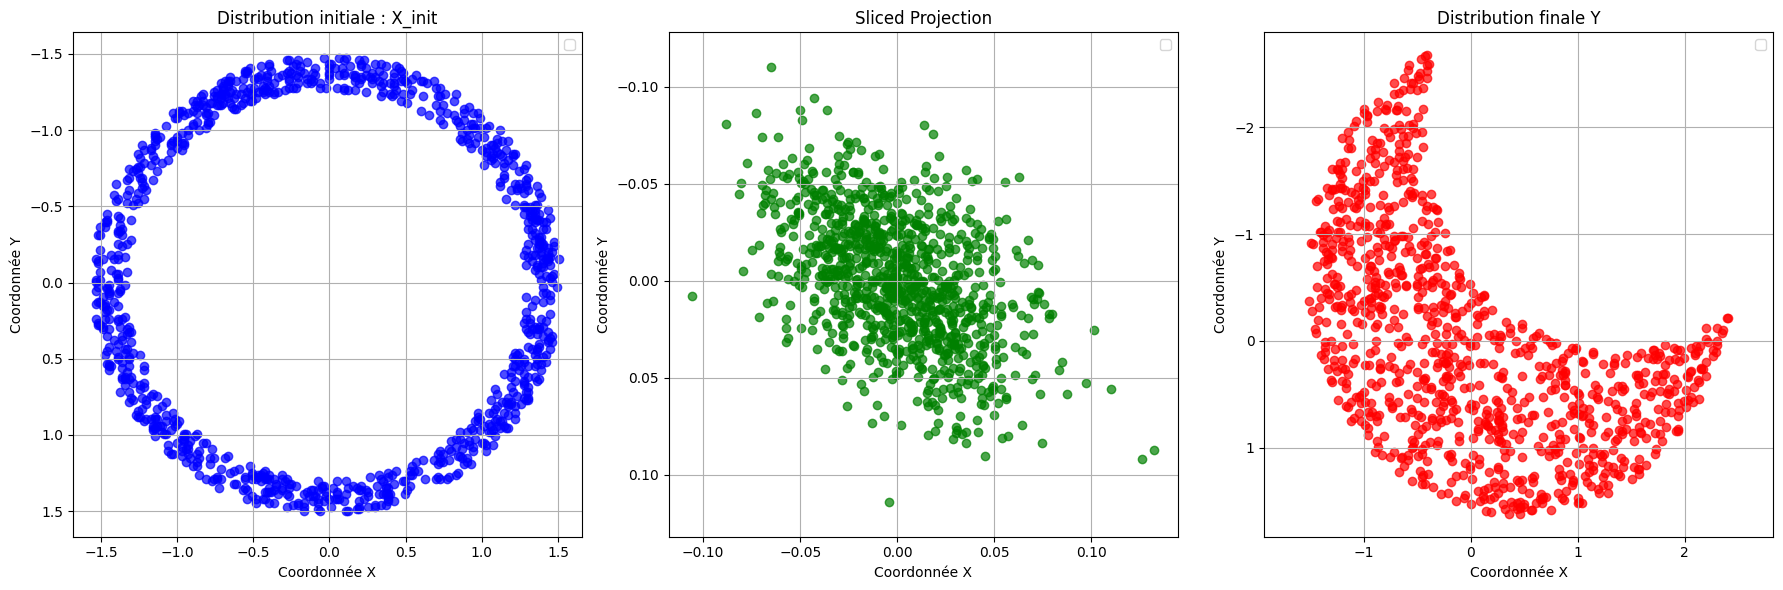

In [112]:

# Normalisation de X_final
X_all_final_normalized = [normalize(X_f) for X_f in X_all]
plot(X_all)

In [100]:
def plot(X_all, nb_iter=-1):
    X_final = X_all[nb_iter]
    plt.figure(figsize=(18, 6))  # Largeur plus grande pour une vue horizontale

    # Affichage des points de X_init (points1_normalized)
    plt.subplot(1, 3, 1)
    plt.scatter(points1_normalized[:, 0], points1_normalized[:, 1], color='blue', alpha=0.7)
    plt.title('Distribution initiale : X_init')
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.gca().invert_yaxis()
    plt.xlabel('Coordonnée X')
    plt.ylabel('Coordonnée Y')
    plt.grid()
    plt.axis('equal')
    plt.legend()

    # Affichage des points normalisés de X_final
    plt.subplot(1, 3, 2)
    plt.scatter(X_final[:, 0], X_final[:, 1], color='green', alpha=0.7)
    plt.title('Sliced Projection')
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.gca().invert_yaxis()
    plt.xlabel('Coordonnée X')
    plt.ylabel('Coordonnée Y')
    plt.grid()
    plt.axis('equal')
    plt.legend()

    # Affichage des points de point2 (points2_normalized)
    plt.subplot(1, 3, 3)
    plt.scatter(points2_normalized[:, 0], points2_normalized[:, 1], color='red', alpha=0.7)
    plt.title('Distribution finale Y')
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.gca().invert_yaxis()
    plt.xlabel('Coordonnée X')
    plt.ylabel('Coordonnée Y')
    plt.grid()
    plt.axis('equal')
    plt.legend()

    plt.tight_layout()
    plt.show()